In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
import astropy.convolution as cv
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import os
import pymc3 as pm

In [3]:
lc = pd.read_table('data/kplr007107778_kasoc-ts_slc_v1.dat', sep='\s+', comment='#', names=['time', 'flux', 'flux_error'], dtype='f8')
psd = pd.read_table('data/kplr007107778_kasoc-psd_slc_v1.pow', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

In [4]:
mask = psd['freq'] > 12
full_freq = psd['freq'][mask].values
power = psd['power'][mask].values
fstep = 1
freq = np.arange(min(full_freq), max(full_freq), fstep)
smoothed_power = cv.convolve(power, cv.Box1DKernel(6 / (full_freq[1] - full_freq[0])))
itrp_power = np.interp(freq, full_freq, smoothed_power)
print(itrp_power.shape)

(8485,)


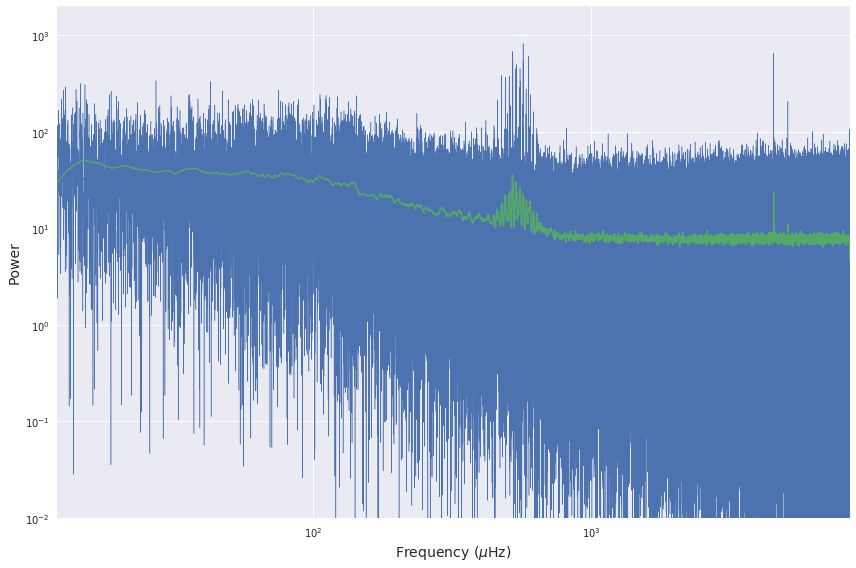

In [33]:
plt.loglog(full_freq, power, lw=.5, alpha=1, c='C0')
plt.loglog(freq, itrp_power, 'C1', lw=1.5)
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout();
plt.savefig('figs/psd_pre.pdf')

In [127]:
v_nyq = 8496.36
R_v = (np.sin( np.pi * freq / (2 * v_nyq)) / ((np.pi * freq) / (2 * v_nyq)))**2
k = 3
with pm.Model() as max_model:
    W = pm.Bound(pm.Normal, lower=0)('W', mu=12, sd=5)
    a = pm.Normal('a', mu=np.array([59, 67, 76]).reshape(k,1), sd=20, shape=(k,1))
    b = pm.Normal('b', mu=np.array([5, 150, 400]).reshape(k,1), sd=np.array([10, 50, 100]).reshape(k,1), shape=(k,1))
    
    harv = pm.math.sum(2 * pm.math.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq/b)**4), axis=0)
    
    H0 = pm.Bound(pm.Normal, lower=0)('H0', mu=17, sd=1)
    v_max = pm.Bound(pm.Normal, lower=0)('v_max', mu=568, sd=5)
    s = pm.Cauchy('s', 55, 10)
    
    env = pm.Normal.dist(mu=v_max, sd=s).logp(freq)
    like = W + R_v * (harv + H0**2 * pm.math.exp(env))
    e = pm.HalfCauchy('e', 10)
    y = pm.Normal('obs', mu=like, sd=e, observed=itrp_power)
    

In [128]:
with max_model:
    trace = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, s, v_max_lowerbound__, H0_lowerbound__, b, a, W_lowerbound__]
100%|██████████| 4000/4000 [03:36<00:00, 18.51it/s]


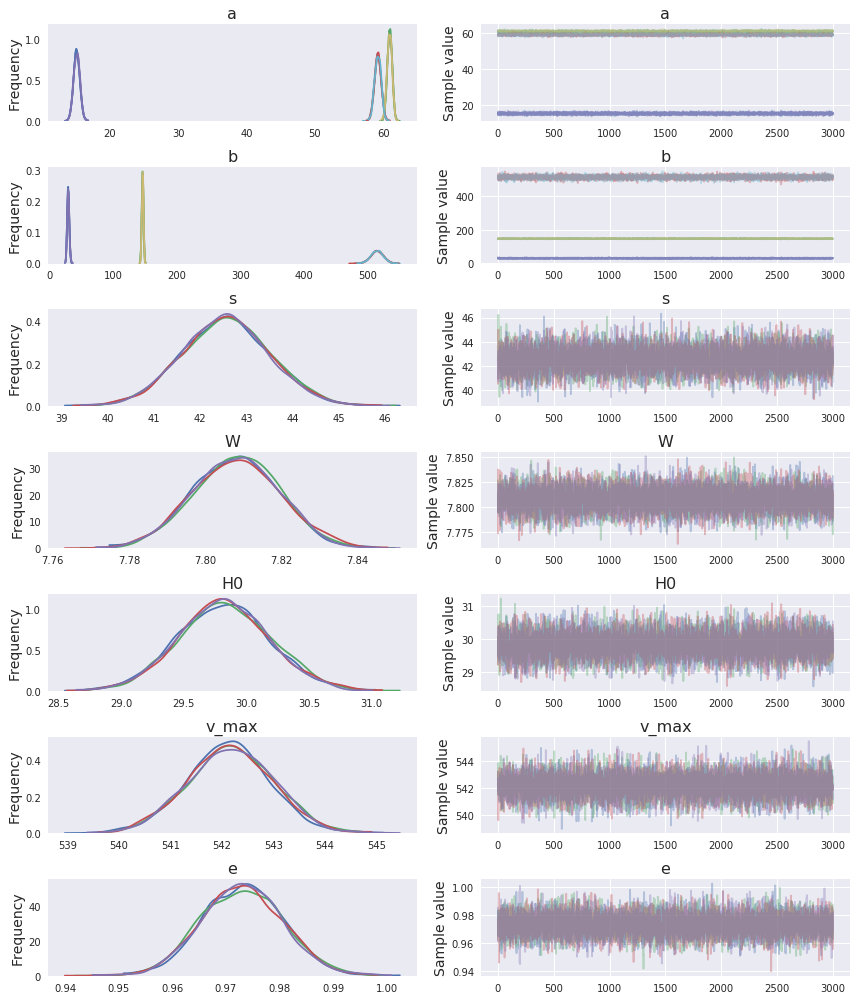

In [129]:
pm.traceplot(trace);
plt.savefig('figs/trace1.pdf')

In [130]:
summ = pm.summary(trace)
summ.to_csv('trace_summary')
summ

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a__0_0,15.149318,0.459138,0.004392,14.275053,16.074465,11126.0,1.000195
a__1_0,60.960751,0.354867,0.003857,60.293530,61.663376,9458.0,1.000060
a__2_0,59.226158,0.477185,0.005080,58.317852,60.172775,9561.0,0.999990
b__0_0,29.762012,1.641102,0.016626,26.606455,33.000675,11648.0,1.000195
b__1_0,146.554047,1.344633,0.014665,143.953522,149.245331,8729.0,0.999912
b__2_0,514.696289,9.656206,0.099528,495.883423,533.769531,9412.0,1.000094
s,42.566483,0.946623,0.009614,40.687721,44.396824,9747.0,1.000099
W,7.808211,0.011442,0.000104,7.786159,7.830865,12000.0,1.000054
H0,29.822407,0.362929,0.003791,29.101307,30.530239,9108.0,1.000154
v_max,542.155273,0.825946,0.007122,540.534607,543.751831,12000.0,1.000339


In [131]:
ppc = pm.sample_ppc(trace, 1000, max_model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:01<00:00, 712.52it/s]


In [132]:
def harvey(v, a, b):
    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (v/b)**4)

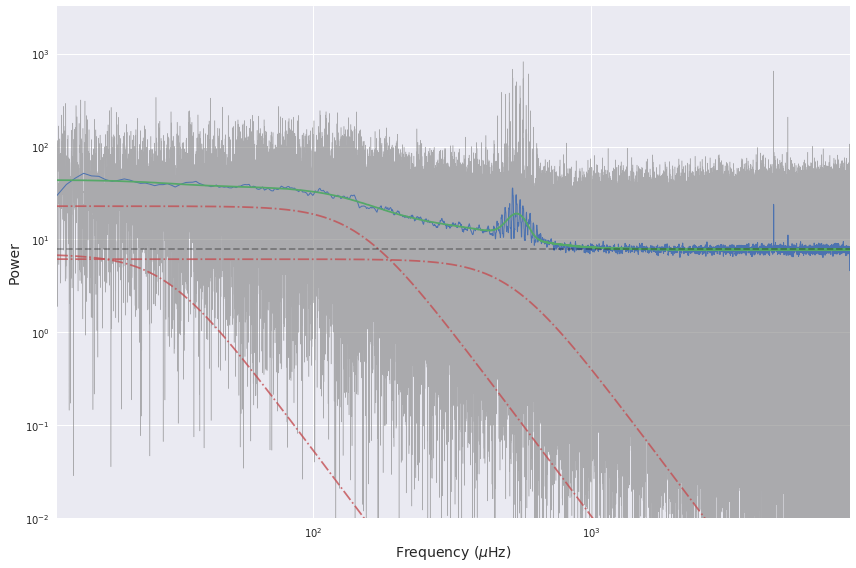

In [133]:
plt.loglog(full_freq, power, lw=.5, alpha=.6, c='.5')
plt.loglog(freq, itrp_power, 'C0', lw=1)
plt.loglog(freq, post, 'C1')
# plt.axvline(trace['v_max'].mean(), c='k', ls='--')
a = trace.get_values('a').mean(axis=0)
b = trace.get_values('b').mean(axis=0)
[plt.loglog(freq, harv, 'C2-.', alpha=.8) for harv in harvey(freq, a, b)]
plt.axhline(trace.get_values('W').mean(), c='k', alpha=.3, ls='--')
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('figs/psd_fit.pdf')

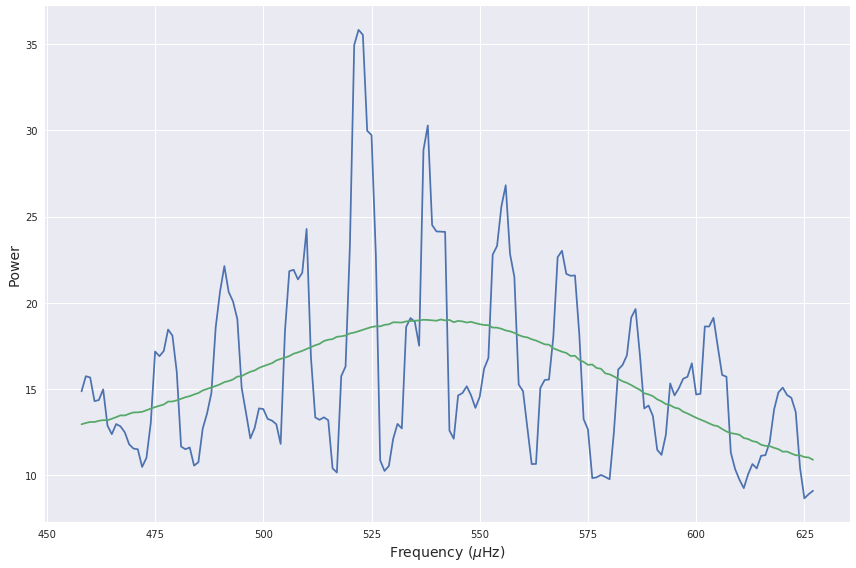

In [134]:
s = trace.get_values('s').mean(axis=0)
v_max = trace.get_values('v_max').mean(axis=0)
mask = (full_freq > (v_max - 2 * s)) & (full_freq < (v_max + 2 * s))
m = (freq > (v_max - 2 * s)) & (freq < (v_max + 2 * s))
subfreq = full_freq[mask]
subpower = power[mask]
plt.plot(freq[m], itrp_power[m])
plt.plot(freq[m], post[m])
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('figs/env_fit.pdf')

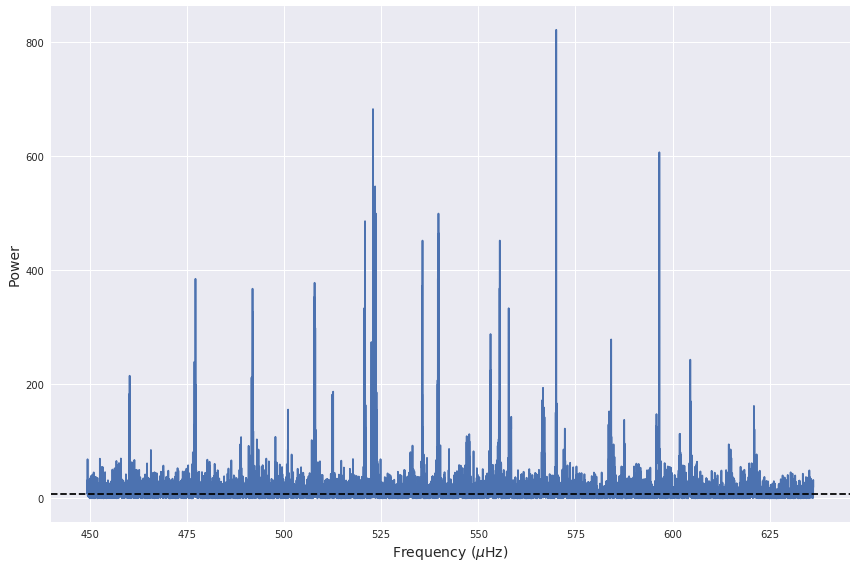

In [75]:
s = trace.get_values('s').mean(axis=0)
v_max = trace.get_values('v_max').mean(axis=0)
mask = (full_freq > (v_max - 2 * s)) & (full_freq < (v_max + 2 * s))
subfreq = full_freq[mask]
subpower = power[mask]
plt.plot(subfreq, subpower)
plt.axhline(trace.get_values('W').mean(), c='k', ls='--')
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('figs/env.pdf')

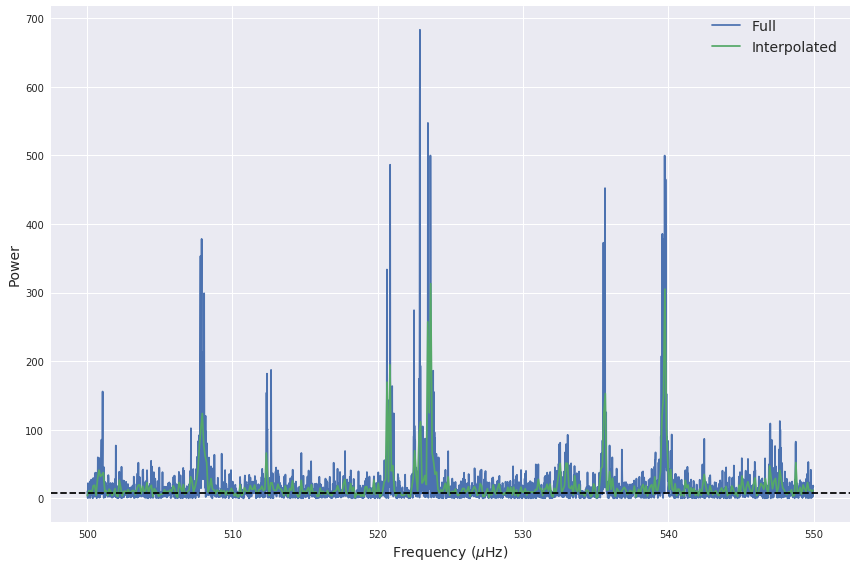

In [103]:
mask = (full_freq > 515) & (full_freq < 550)
ff = full_freq[mask]
pp = power[mask]

fstep = ff[1]-ff[0]
subfreq = np.linspace(min(ff), max(ff), 500)
smp = cv.convolve(pp, cv.Box1DKernel(3))
subpower = np.interp(subfreq, ff, smp)

# print(subpower.shape)
plt.plot(ff, pp, label='Full')
plt.plot(subfreq, subpower, label='Interpolated')
plt.axhline(trace.get_values('W').mean(axis=0), ls='--', c='k')
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.legend()
plt.savefig('figs/subenv.pdf')

In [104]:
modes = np.array([520, 523, 533,  536, 540,])
n = len(modes)
v_nyq = 8496.36
R_v = (np.sin( np.pi * subfreq / (2 * v_nyq)) / ((np.pi * subfreq) / (2 * v_nyq)))**2
import theano.tensor as tt
from io import StringIO
import sys

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO() 

with pm.Model() as mode_model:
    A = tt.printing.Print('A')(pm.Bound(pm.Normal, lower=0)('A', mu=20, sd=10, shape=(n,1)))
    v0 = tt.printing.Print('v0')(pm.Normal('v0', mu=modes.reshape(n,1), sd=5, shape=(n,1)))
#     L = pm.Bound(pm.Normal, lower=0)('L', mu=.12, sd=1, shape=(n,1))
    L = tt.printing.Print('L')(pm.HalfCauchy('L', beta=1, shape=(n,1)))
    
    e = pm.HalfCauchy('e', 10)
#     env = A**2 * pm.Cauchy.dist(alpha=v0, beta=L).logp(ff)
    env = (A**2 / (np.pi * L)) / (1 + 4 * ( subfreq - v0)**2 / L**2)
    like = tt.printing.Print('y')(R_v * pm.math.sum(env, axis=0) + trace['W'].mean())
    
    y = pm.Normal('obs', mu=like, sd=e, observed=subpower)

In [105]:
with mode_model:
    mode_trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, L_log__, v0, A_lowerbound__]
 14%|█▎        | 406/3000 [15:19<1:37:54,  2.26s/it]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f8100472540, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ec2-user/anaconda3/envs/theano_p36/lib/pyt...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ec2-us.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f8100472540, file "/...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ec2-user/anaconda3/envs/theano_p36/lib/pyt...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ec2-us.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except (RuntimeError, AssertionError):
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1426                         logger.warning('Executing %s took %.3f seconds',
   1427                                        _format_handle(handle), dt)
   1428                 finally:
   1429                     self._current_handle = None
   1430             else:
-> 1431                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(11, 1)>>
   1432         handle = None  # Needed to break cycles when an exception occurs.
   1433 
   1434     def _set_coroutine_wrapper(self, enabled):
   1435         try:

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(11, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (11, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=11, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 26, 22, 49, 51, 126150, tzinfo=tzlocal()), 'msg_id': 'd4156d8bfb7d98d9792ac1edb12c873e', 'msg_type': 'execute_request', 'session': '78bd94d3273851a49dc2e87c7fc8c8b2', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd4156d8bfb7d98d9792ac1edb12c873e', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'78bd94d3273851a49dc2e87c7fc8c8b2']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 26, 22, 49, 51, 126150, tzinfo=tzlocal()), 'msg_id': 'd4156d8bfb7d98d9792ac1edb12c873e', 'msg_type': 'execute_request', 'session': '78bd94d3273851a49dc2e87c7fc8c8b2', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd4156d8bfb7d98d9792ac1edb12c873e', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'78bd94d3273851a49dc2e87c7fc8c8b2'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 26, 22, 49, 51, 126150, tzinfo=tzlocal()), 'msg_id': 'd4156d8bfb7d98d9792ac1edb12c873e', 'msg_type': 'execute_request', 'session': '78bd94d3273851a49dc2e87c7fc8c8b2', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd4156d8bfb7d98d9792ac1edb12c873e', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-105-a852d78c3303>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f803d2a8e10, executi...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f8058141c90, file "<ipython-input-105-a852d78c3303>", line 1>
        result = <ExecutionResult object at 7f803d2a8e10, executi...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f8058141c90, file "<ipython-input-105-a852d78c3303>", line 1>, result=<ExecutionResult object at 7f803d2a8e10, executi...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f8058141c90, file "<ipython-input-105-a852d78c3303>", line 1>
        self.user_global_ns = {'A': Print{message='A', attrs=('__str__',), global_fn=<function _print_fn at 0x7f80b997dd90>}.0, 'H0': H0, 'In': ['', "get_ipython().run_line_magic('matplotlib', 'inli...iron.update({'DEVICE': 'cpu'})\nimport pymc3 as pm", "get_ipython().run_line_magic('matplotlib', 'inli...Params.update(style)\nimport os\nimport pymc3 as pm", "lc = pd.read_table('data/kplr007107778_kasoc-ts_...comment='#', names=['freq', 'power'], dtype='f8')", "mask = psd['freq'] > 12\nfull_freq = psd['freq'][...ull_freq, smoothed_power)\nprint(itrp_power.shape)", 'plt.loglog(full_freq, power)\nplt.loglog(freq, itrp_power);', "v_nyq = 8496.36\nR_v = (np.sin( np.pi * freq / (2...l('obs', mu=like, sd=e, observed=itrp_power)\n    ", 'with max_model:\n    trace = pm.sample(3000, tune=1000)', 'pm.traceplot(trace);', 'pm.summary(trace)', "ppc = pm.sample_ppc(trace, 1000, max_model)\npost = ppc['obs'].mean(axis=0)", 'def harvey(v, a, b):\n    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (v/b)**4)', "plt.loglog(full_freq, power, lw=.5, alpha=.6, c=...\\mu$Hz)')\nplt.ylabel('Power')\nplt.tight_layout();", "s = trace.get_values('s').mean(axis=0)\nv_max = t...t(subfreq, subpower)\nplt.plot(freq[m2], post[m2])", "mask = (full_freq > 565) & (full_freq < 575)\nff ...ace.get_values('W').mean(axis=0), ls='--', c='k')", "modes = np.array([567, 570, 572,])\nn = len(modes...m.Normal('obs', mu=like, sd=e, observed=subpower)", 'with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)', "sys.stdout = old_stdout\n\noutput = mystdout.getvalue().split('\\n')\nprint(output[-10:])", 'pm.traceplot(mode_trace);', "prof = pm.sample_ppc(mode_trace, 1000, mode_model)['obs'].mean(axis=0)", ...], 'L': Print{message='L', attrs=('__str__',), global_fn=<function _print_fn at 0x7f80b997dd90>}.0, 'LombScargle': <class 'astropy.stats.lombscargle.core.LombScargle'>, 'Out': {9:               mean        sd  mc_error     hpd_2... 1.000050  
s       1.000035  
e       0.999890  , 13: [<matplotlib.lines.Line2D object>], 14: <matplotlib.lines.Line2D object>, 20: [<matplotlib.lines.Line2D object>], 23: [<matplotlib.lines.Line2D object>], 24: [<matplotlib.lines.Line2D object>], 25: [<matplotlib.lines.Line2D object>], 36:               mean        sd  mc_error     hpd_2... 1.000050  
s       1.000035  
e       0.999890  , 42:               mean        sd  mc_error     hpd_2... 0.999911  
s       0.999868  
e       1.000148  , 46: [<matplotlib.lines.Line2D object>], ...}, 'R_v': array([0.99715479, 0.99715365, 0.99715252, 0.997... 0.99656219, 0.99656094, 0.99655969, 0.99655844]), 'StringIO': <class '_io.StringIO'>, 'W': W, '_':                mean         sd  mc_error     hpd....000895  
L__2_0   1.000668  
e        0.999956  , ...}
        self.user_ns = {'A': Print{message='A', attrs=('__str__',), global_fn=<function _print_fn at 0x7f80b997dd90>}.0, 'H0': H0, 'In': ['', "get_ipython().run_line_magic('matplotlib', 'inli...iron.update({'DEVICE': 'cpu'})\nimport pymc3 as pm", "get_ipython().run_line_magic('matplotlib', 'inli...Params.update(style)\nimport os\nimport pymc3 as pm", "lc = pd.read_table('data/kplr007107778_kasoc-ts_...comment='#', names=['freq', 'power'], dtype='f8')", "mask = psd['freq'] > 12\nfull_freq = psd['freq'][...ull_freq, smoothed_power)\nprint(itrp_power.shape)", 'plt.loglog(full_freq, power)\nplt.loglog(freq, itrp_power);', "v_nyq = 8496.36\nR_v = (np.sin( np.pi * freq / (2...l('obs', mu=like, sd=e, observed=itrp_power)\n    ", 'with max_model:\n    trace = pm.sample(3000, tune=1000)', 'pm.traceplot(trace);', 'pm.summary(trace)', "ppc = pm.sample_ppc(trace, 1000, max_model)\npost = ppc['obs'].mean(axis=0)", 'def harvey(v, a, b):\n    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (v/b)**4)', "plt.loglog(full_freq, power, lw=.5, alpha=.6, c=...\\mu$Hz)')\nplt.ylabel('Power')\nplt.tight_layout();", "s = trace.get_values('s').mean(axis=0)\nv_max = t...t(subfreq, subpower)\nplt.plot(freq[m2], post[m2])", "mask = (full_freq > 565) & (full_freq < 575)\nff ...ace.get_values('W').mean(axis=0), ls='--', c='k')", "modes = np.array([567, 570, 572,])\nn = len(modes...m.Normal('obs', mu=like, sd=e, observed=subpower)", 'with mode_model:\n    mode_trace = pm.sample(2000, tune=1000)', "sys.stdout = old_stdout\n\noutput = mystdout.getvalue().split('\\n')\nprint(output[-10:])", 'pm.traceplot(mode_trace);', "prof = pm.sample_ppc(mode_trace, 1000, mode_model)['obs'].mean(axis=0)", ...], 'L': Print{message='L', attrs=('__str__',), global_fn=<function _print_fn at 0x7f80b997dd90>}.0, 'LombScargle': <class 'astropy.stats.lombscargle.core.LombScargle'>, 'Out': {9:               mean        sd  mc_error     hpd_2... 1.000050  
s       1.000035  
e       0.999890  , 13: [<matplotlib.lines.Line2D object>], 14: <matplotlib.lines.Line2D object>, 20: [<matplotlib.lines.Line2D object>], 23: [<matplotlib.lines.Line2D object>], 24: [<matplotlib.lines.Line2D object>], 25: [<matplotlib.lines.Line2D object>], 36:               mean        sd  mc_error     hpd_2... 1.000050  
s       1.000035  
e       0.999890  , 42:               mean        sd  mc_error     hpd_2... 0.999911  
s       0.999868  
e       1.000148  , 46: [<matplotlib.lines.Line2D object>], ...}, 'R_v': array([0.99715479, 0.99715365, 0.99715252, 0.997... 0.99656219, 0.99656094, 0.99655969, 0.99655844]), 'StringIO': <class '_io.StringIO'>, 'W': W, '_':                mean         sd  mc_error     hpd....000895  
L__2_0   1.000668  
e        0.999956  , ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/home/ec2-user/stat444/project/<ipython-input-105-a852d78c3303> in <module>()
      1 with mode_model:
----> 2     mode_trace = pm.sample(2000, tune=1000)

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=3000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'A_lowerbound__': array([[-0.42482057],
       [-0.4112274 ],
    ....62935996],
       [ 0.5180536 ]], dtype=float32), 'L_log__': array([[ 0.8107706 ],
       [ 0.8487257 ],
    ....09502247],
       [ 0.05048286]], dtype=float32), 'e_log__': array(3.049099, dtype=float32), 'v0': array([[499.1023 ],
       [508.0796 ],
       [... [536.85266],
       [539.1938 ]], dtype=float32)}, {'A_lowerbound__': array([[ 0.51312286],
       [ 0.91398805],
    ....43811092],
       [-0.7410699 ]], dtype=float32), 'L_log__': array([[-0.49863905],
       [-0.6512487 ],
    ....88258386],
       [ 0.8590727 ]], dtype=float32), 'e_log__': array(2.2841098, dtype=float32), 'v0': array([[500.2011 ],
       [508.2257 ],
       [... [535.62225],
       [539.6285 ]], dtype=float32)}, {'A_lowerbound__': array([[-0.4712023 ],
       [ 0.98200285],
    ....34629694],
       [-0.5255076 ]], dtype=float32), 'L_log__': array([[-0.9610311 ],
       [ 0.32533503],
    ....90286016],
       [-0.02731491]], dtype=float32), 'e_log__': array(2.043203, dtype=float32), 'v0': array([[500.91782],
       [508.42014],
       [... [535.95544],
       [539.1122 ]], dtype=float32)}, {'A_lowerbound__': array([[-0.73978853],
       [-0.3990202 ],
    ....16894127],
       [-0.18846402]], dtype=float32), 'L_log__': array([[ 0.45006293],
       [-0.22646713],
    ....06498869],
       [-0.78780025]], dtype=float32), 'e_log__': array(1.7120054, dtype=float32), 'v0': array([[500.7619 ],
       [508.82144],
       [... [535.839  ],
       [540.8013 ]], dtype=float32)}], trace=None, chain_idx=0, chains=4, njobs=4, tune=1000, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[635311684, 968025389, 735635963, 648638244], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs={})
    414     parallel = njobs > 1 and chains > 1 and not has_population_samplers
    415     if parallel:
    416         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, njobs))
    417         _print_step_hierarchy(step)
    418         try:
--> 419             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 4, 'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 4, 'progressbar': True, 'random_seed': [635311684, 968025389, 735635963, 648638244], 'start': [{'A_lowerbound__': array([[-0.42482057],
       [-0.4112274 ],
    ....62935996],
       [ 0.5180536 ]], dtype=float32), 'L_log__': array([[ 0.8107706 ],
       [ 0.8487257 ],
    ....09502247],
       [ 0.05048286]], dtype=float32), 'e_log__': array(3.049099, dtype=float32), 'v0': array([[499.1023 ],
       [508.0796 ],
       [... [536.85266],
       [539.1938 ]], dtype=float32)}, {'A_lowerbound__': array([[ 0.51312286],
       [ 0.91398805],
    ....43811092],
       [-0.7410699 ]], dtype=float32), 'L_log__': array([[-0.49863905],
       [-0.6512487 ],
    ....88258386],
       [ 0.8590727 ]], dtype=float32), 'e_log__': array(2.2841098, dtype=float32), 'v0': array([[500.2011 ],
       [508.2257 ],
       [... [535.62225],
       [539.6285 ]], dtype=float32)}, {'A_lowerbound__': array([[-0.4712023 ],
       [ 0.98200285],
    ....34629694],
       [-0.5255076 ]], dtype=float32), 'L_log__': array([[-0.9610311 ],
       [ 0.32533503],
    ....90286016],
       [-0.02731491]], dtype=float32), 'e_log__': array(2.043203, dtype=float32), 'v0': array([[500.91782],
       [508.42014],
       [... [535.95544],
       [539.1122 ]], dtype=float32)}, {'A_lowerbound__': array([[-0.73978853],
       [-0.3990202 ],
    ....16894127],
       [-0.18846402]], dtype=float32), 'L_log__': array([[ 0.45006293],
       [-0.22646713],
    ....06498869],
       [-0.78780025]], dtype=float32), 'e_log__': array(1.7120054, dtype=float32), 'v0': array([[500.7619 ],
       [508.82144],
       [... [535.839  ],
       [540.8013 ]], dtype=float32)}], ...}
    420         except pickle.PickleError:
    421             _log.warn("Could not pickle model, sampling singlethreaded.")
    422             _log.debug('Pickling error:', exec_info=True)
    423             parallel = False

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})
    944 
    945     chain_nums = list(range(chain, chain + chains))
    946     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    947     jobs = (delayed(_sample)(*args, **kwargs)
    948             for args in zip(chain_nums, pbars, rseed, start))
--> 949     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 4
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    950     return MultiTrace(traces)
    951 
    952 
    953 def stop_tuning(step):

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Apr 26 23:05:12 2018
PID: 27401Python 3.6.4: /home/ec2-user/anaconda3/envs/theano_p36/bin/python
...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 635311684, {'A_lowerbound__': array([[-0.42482057],
       [-0.4112274 ],
    ....62935996],
       [ 0.5180536 ]], dtype=float32), 'L_log__': array([[ 0.8107706 ],
       [ 0.8487257 ],
    ....09502247],
       [ 0.05048286]], dtype=float32), 'e_log__': array(3.049099, dtype=float32), 'v0': array([[499.1023 ],
       [508.0796 ],
       [... [536.85266],
       [539.1938 ]], dtype=float32)}), {'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 635311684, {'A_lowerbound__': array([[-0.42482057],
       [-0.4112274 ],
    ....62935996],
       [ 0.5180536 ]], dtype=float32), 'L_log__': array([[ 0.8107706 ],
       [ 0.8487257 ],
    ....09502247],
       [ 0.05048286]], dtype=float32), 'e_log__': array(3.049099, dtype=float32), 'v0': array([[499.1023 ],
       [508.0796 ],
       [... [536.85266],
       [539.1938 ]], dtype=float32)})
        kwargs = {'draws': 3000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=635311684, start={'A_lowerbound__': array([[-0.42482057],
       [-0.4112274 ],
    ....62935996],
       [ 0.5180536 ]], dtype=float32), 'L_log__': array([[ 0.8107706 ],
       [ 0.8487257 ],
    ....09502247],
       [ 0.05048286]], dtype=float32), 'e_log__': array(3.049099, dtype=float32), 'v0': array([[499.1023 ],
       [508.0796 ],
       [... [536.85266],
       [539.1938 ]], dtype=float32)}, draws=3000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=1000, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    521                             tune, model, random_seed)
    522     if progressbar:
    523         sampling = tqdm(sampling, total=draws)
    524     try:
    525         strace = None
--> 526         for it, strace in enumerate(sampling):
        it = 405
        strace = <pymc3.backends.ndarray.NDArray object>
        sampling =  14%|█▎        | 406/3000 [15:19<1:37:54,  2.26s/it]
    527             if live_plot:
    528                 if live_plot_kwargs is None:
    529                     live_plot_kwargs = {}
    530                 if it >= skip_first:

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self= 14%|█▎        | 406/3000 [15:19<1:37:54,  2.26s/it])
    936             except AttributeError:
    937                 raise TqdmDeprecationWarning("""\
    938 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    939 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    940 
--> 941             for obj in iterable:
        obj = <pymc3.backends.ndarray.NDArray object>
        iterable = <generator object _iter_sample>
    942                 yield obj
    943                 # Update and possibly print the progressbar.
    944                 # Note: does not call self.update(1) for speed optimisation.
    945                 n += 1

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=3000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'A_lowerbound__': array([[-0.42482057],
       [-0.4112274 ],
    ....62935996],
       [ 0.5180536 ]], dtype=float32), 'L_log__': array([[ 0.8107706 ],
       [ 0.8487257 ],
    ....09502247],
       [ 0.05048286]], dtype=float32), 'e_log__': array(3.049099, dtype=float32), 'v0': array([[499.1023 ],
       [508.0796 ],
       [... [536.85266],
       [539.1938 ]], dtype=float32)}, trace=None, chain=0, tune=1000, model=<pymc3.model.Model object>, random_seed=635311684)
    619         step.tune = bool(tune)
    620         for i in range(draws):
    621             if i == tune:
    622                 step = stop_tuning(step)
    623             if step.generates_stats:
--> 624                 point, states = step.step(point)
        point = {'A_lowerbound__': array([[1.5262835],
       [3.1416893],
       [... [3.1963751],
       [2.542019 ]], dtype=float32), 'L_log__': array([[-1.1548443],
       [ 4.32617  ],
      ... 3.8189173],
       [-1.7040894]], dtype=float32), 'e_log__': array(2.6936576, dtype=float32), 'v0': array([[500.8111 ],
       [508.4489 ],
       [... [536.39276],
       [539.7573 ]], dtype=float32)}
        states = [{'depth': 10, 'diverging': False, 'energy': 2157.679172165184, 'energy_error': -0.16006385176660842, 'max_energy_error': 0.2609840060231363, 'mean_tree_accept': 0.9737515169131588, 'step_size': 0.0005493789652590351, 'step_size_bar': 0.0015215912041367187, 'tree_size': 1023, 'tune': True}]
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    625                 if strace.supports_sampler_stats:
    626                     strace.record(point, states)
    627                 else:
    628                     strace.record(point)

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'A_lowerbound__': array([[1.5262835],
       [3.1416893],
       [... [3.1963751],
       [2.542019 ]], dtype=float32), 'L_log__': array([[-1.1548443],
       [ 4.32617  ],
      ... 3.8189173],
       [-1.7040894]], dtype=float32), 'e_log__': array(2.6936576, dtype=float32), 'v0': array([[500.8111 ],
       [508.4489 ],
       [... [536.39276],
       [539.7573 ]], dtype=float32)})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([  2.6936576,  -1.1548443,   4.32617  ,  -...,   3.1963751,   2.542019 ],
      dtype=float32)
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([  2.6936576,  -1.1548443,   4.32617  ,  -...,   3.1963751,   2.542019 ],
      dtype=float32))
    110         """Perform a single HMC iteration."""
    111         p0 = self.potential.random()
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
--> 115             self.potential.raise_ok()
        self.potential.raise_ok = <bound method QuadPotentialDiagAdapt.raise_ok of...hmc.quadpotential.QuadPotentialDiagAdapt object>>
    116             raise ValueError('Bad initial energy: %s. The model '
    117                              'might be misspecified.' % start.energy)
    118 
    119         adapt_step = self.tune and self.adapt_step_size

...........................................................................
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py in raise_ok(self=<pymc3.step_methods.hmc.quadpotential.QuadPotentialDiagAdapt object>)
    185 
    186         self._n_samples += 1
    187 
    188     def raise_ok(self):
    189         if np.any(self._stds == 0):
--> 190             raise ValueError('Mass matrix contains zeros on the diagonal. '
    191                              'Some derivatives might always be zero.')
    192         if np.any(self._stds < 0):
    193             raise ValueError('Mass matrix contains negative values on the '
    194                              'diagonal.')

ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.
___________________________________________________________________________

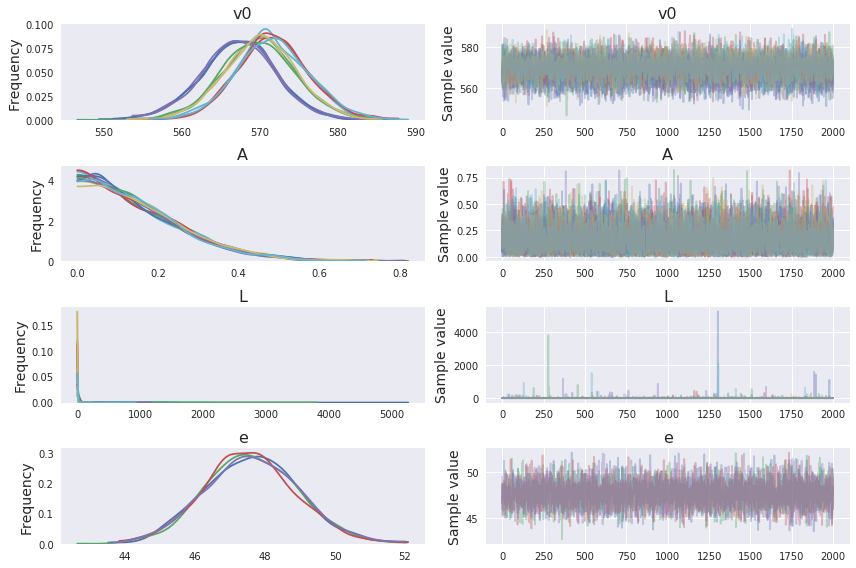

In [83]:
pm.traceplot(mode_trace);
plt.savefig('figs/mode_trace.pdf')

In [84]:
prof = pm.sample_ppc(mode_trace, 1000, mode_model)['obs'].mean(axis=0)
sys.stdout = old_stdout

100%|██████████| 1000/1000 [00:07<00:00, 125.05it/s]


In [85]:
mode_summ = pm.summary(mode_trace)
mode_summ.to_csv('mode_summ.csv')
mode_summ

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
v0__0_0,567.294434,4.798394,0.056102,557.542175,576.622620,6918.0,0.999858
v0__1_0,569.931091,4.752278,0.062598,560.683411,579.619263,6472.0,1.000308
v0__2_0,571.605347,4.610667,0.055792,562.996460,581.049500,6464.0,1.000583
A__0_0,0.155045,0.122229,0.001476,0.000116,0.394106,6573.0,1.000402
A__1_0,0.160380,0.124079,0.001569,0.000026,0.402876,7225.0,1.000062
A__2_0,0.157177,0.124052,0.001523,0.000139,0.397840,6402.0,0.999851
L__0_0,5.804298,71.659805,0.947690,0.000104,12.158970,5410.0,0.999803
L__1_0,4.503172,50.674728,0.823532,0.000202,10.991575,3739.0,1.000895
L__2_0,4.973088,37.581406,0.560769,0.000224,13.266747,4300.0,1.000668
e,47.601727,1.331903,0.016290,44.953732,50.202591,5393.0,0.999956


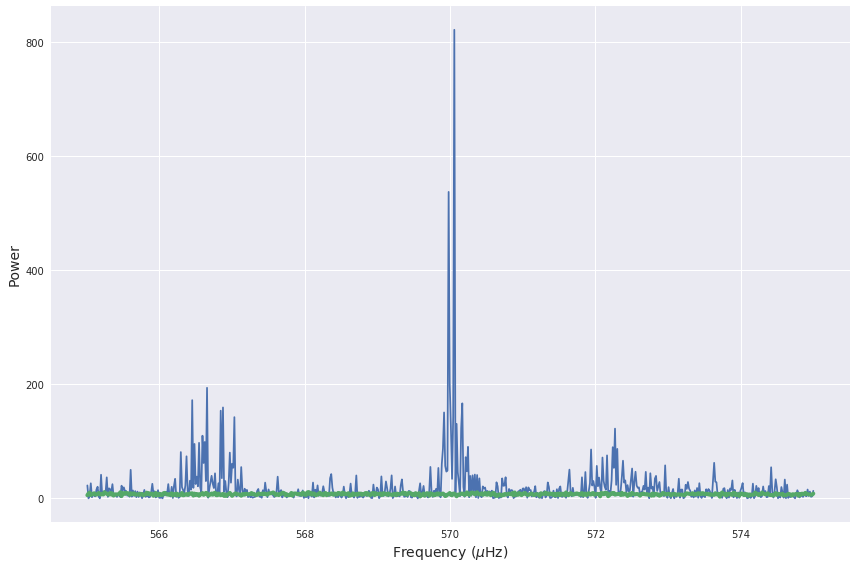

In [87]:
plt.plot(ff, pp)
plt.plot(ff, prof, 'C1', lw=4)
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('figs/mode_fit.pdf')

In [17]:


output = mystdout.getvalue().split('\n')
print(output[-10:])